In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_basepath="../../data/content/playground/auto/nostem",
                         basepath_suffix="_content.csv",
                         content_categories=product_list,
                         vector_length=500)

# initialize the vocab of documents and minimize the distances of embeddings in training phase
d2v_wrapper.init_model_vocab()
d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 10)

# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-04-03 13:16:20,946 : INFO : collecting all words and their counts
2017-04-03 13:16:20,947 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-03 13:16:21,336 : INFO : PROGRESS: at example #10000, processed 1393592 words (3598566/s), 63275 word types, 10000 tags
2017-04-03 13:16:21,597 : INFO : PROGRESS: at example #20000, processed 2550277 words (4442893/s), 95498 word types, 20000 tags
2017-04-03 13:16:21,926 : INFO : PROGRESS: at example #30000, processed 4063349 words (4635609/s), 124345 word types, 30000 tags
2017-04-03 13:16:22,205 : INFO : PROGRESS: at example #40000, processed 5280834 words (4363979/s), 147174 word types, 40000 tags
2017-04-03 13:16:22,466 : INFO : PROGRESS: at example #50000, processed 6427786 words (4406828/s), 175998 word types, 50000 tags
2017-04-03 13:16:22,691 : INFO : PROGRESS: at example #60000, processed 7236898 words (3612461/s), 205437 word types, 60000 tags
2017-04-03 13:16:22,977 : INFO : PROGRESS: at example

KeyboardInterrupt: 

In [4]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [5]:
# encoding/decoding target categories
mapping = []


def encode_categories(target_series):
    global mapping
    if not len(mapping):
        for cat in target_series.unique():
            mapping.append(cat)

    return target_series.apply(lambda cat_str: mapping.index(cat_str))


def decode_categories(target_series):
    global mapping
    return target_series.apply(lambda cat_idx: mapping[cat_idx])

In [ ]:
# transforms the given content to Tensorflow format
def dataset_from_dataframe(data_df, target_series):
    dataset = tf.contrib.learn.datasets.base.Dataset(data=data_df.values, target=encode_categories(target_series))
    return dataset

In [11]:
# classifier training and eval:
from sklearn.linear_model import LogisticRegression

accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
correct_logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    # training
    log_reg_classifier = LogisticRegression(solver="newton-cg", multi_class='ovr', n_jobs=8)
    log_reg_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])

    # testing
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = log_reg_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    class_probabs = log_reg_classifier.predict_proba(doc_vectors.iloc[test_doc_indices])
    class_labels_sorted = doc_labels.iloc[train_doc_indices].unique()
    class_actual = pd.Series(y_actual).apply(lambda cat_label: )

    logits = two_layer_nn_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    y_actual = decode_categories(pd.Series(logits["classes"])).values
    y_expected = doc_labels.iloc[test_doc_indices].values

    # evaluation:
    # logits
    actual_prob = logits["probabilities"][np.arange(len(logits["probabilities"])),(logits["classes"])]
    expected_prob = logits["probabilities"][np.arange(len(logits["probabilities"])),(encode_categories(pd.Series(y_expected)))]
    new_logits = pd.DataFrame()
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    correct_logits = correct_logits.append(new_logits)
    
    # accuracy
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.warn("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.warn("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))
    
    # misclassified docs collection
    wrong_docs_ids = wrong_docs_ids.append(pd.Series(test_doc_indices[y_actual != y_expected]))

2017-04-03 10:40:26,491 : WARNING : Using temporary folder as model directory: /tmp/tmp7MTC5g


INFO:tensorflow:Using default config.


2017-04-03 10:40:26,492 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f981ddece10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 10:40:26,493 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f981ddece10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 10:40:26,494 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 10:40:26,564 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 10:40:26,829 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp7MTC5g/model.ckpt.


2017-04-03 10:40:28,506 : INFO : Saving checkpoints for 1 into /tmp/tmp7MTC5g/model.ckpt.


INFO:tensorflow:loss = 2.34256, step = 1


2017-04-03 10:40:28,941 : INFO : loss = 2.34256, step = 1


INFO:tensorflow:global_step/sec: 176.257


2017-04-03 10:40:29,506 : INFO : global_step/sec: 176.257


INFO:tensorflow:loss = 0.67149, step = 101


2017-04-03 10:40:29,509 : INFO : loss = 0.67149, step = 101


INFO:tensorflow:global_step/sec: 171.857


2017-04-03 10:40:30,088 : INFO : global_step/sec: 171.857


INFO:tensorflow:loss = 0.513208, step = 201


2017-04-03 10:40:30,091 : INFO : loss = 0.513208, step = 201


INFO:tensorflow:global_step/sec: 173.936


2017-04-03 10:40:30,663 : INFO : global_step/sec: 173.936


INFO:tensorflow:loss = 0.78488, step = 301


2017-04-03 10:40:30,666 : INFO : loss = 0.78488, step = 301


INFO:tensorflow:global_step/sec: 171.327


2017-04-03 10:40:31,247 : INFO : global_step/sec: 171.327


INFO:tensorflow:loss = 0.670863, step = 401


2017-04-03 10:40:31,250 : INFO : loss = 0.670863, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp7MTC5g/model.ckpt.


2017-04-03 10:40:31,824 : INFO : Saving checkpoints for 500 into /tmp/tmp7MTC5g/model.ckpt.


INFO:tensorflow:Loss for final step: 0.689751.


2017-04-03 10:40:32,251 : INFO : Loss for final step: 0.689751.


2017-04-03 10:40:32,365 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 10:40:32,732 : WARNING : Run accuracy: 0.795738565359
2017-04-03 10:40:32,740 : WARNING : Cat accuracies:
[0.2545454545454545, 0.6860759493670886, 0.625, 0.866988416988417, 0.5584642233856894, 0.43112947658402206, 0.8643006263048016, 0.35714285714285715, 0.0, 0.8806]


2017-04-03 10:40:32,814 : WARNING : Using temporary folder as model directory: /tmp/tmp1kwoUt


INFO:tensorflow:Using default config.


2017-04-03 10:40:32,815 : INFO : Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f981eaf06d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 10:40:32,816 : INFO : Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f981eaf06d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


2017-04-03 10:40:32,817 : WARNING : float64 is not supported by many models, consider casting to float32.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


2017-04-03 10:40:32,888 : WARNING : From /usr/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:1362: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


2017-04-03 10:40:33,149 : INFO : Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp1kwoUt/model.ckpt.


2017-04-03 10:40:34,955 : INFO : Saving checkpoints for 1 into /tmp/tmp1kwoUt/model.ckpt.


INFO:tensorflow:loss = 2.43467, step = 1


2017-04-03 10:40:35,241 : INFO : loss = 2.43467, step = 1


INFO:tensorflow:global_step/sec: 169.063


2017-04-03 10:40:35,831 : INFO : global_step/sec: 169.063


INFO:tensorflow:loss = 0.466881, step = 101


2017-04-03 10:40:35,834 : INFO : loss = 0.466881, step = 101


INFO:tensorflow:global_step/sec: 174.402


2017-04-03 10:40:36,404 : INFO : global_step/sec: 174.402


INFO:tensorflow:loss = 0.571295, step = 201


2017-04-03 10:40:36,406 : INFO : loss = 0.571295, step = 201


INFO:tensorflow:global_step/sec: 173.248


2017-04-03 10:40:36,981 : INFO : global_step/sec: 173.248


INFO:tensorflow:loss = 0.670612, step = 301


2017-04-03 10:40:36,984 : INFO : loss = 0.670612, step = 301


INFO:tensorflow:global_step/sec: 170.033


2017-04-03 10:40:37,569 : INFO : global_step/sec: 170.033


INFO:tensorflow:loss = 0.682044, step = 401


2017-04-03 10:40:37,572 : INFO : loss = 0.682044, step = 401


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp1kwoUt/model.ckpt.


2017-04-03 10:40:38,161 : INFO : Saving checkpoints for 500 into /tmp/tmp1kwoUt/model.ckpt.


INFO:tensorflow:Loss for final step: 0.556985.


2017-04-03 10:40:38,598 : INFO : Loss for final step: 0.556985.


2017-04-03 10:40:38,720 : WARNING : float64 is not supported by many models, consider casting to float32.
2017-04-03 10:40:39,122 : WARNING : Run accuracy: 0.801362585162
2017-04-03 10:40:39,130 : WARNING : Cat accuracies:
[0.06464646464646465, 0.6565272496831432, 0.5, 0.9212203128016991, 0.5013100436681223, 0.44275862068965516, 0.8037578288100209, 0.017857142857142856, 0.0, 0.915]


In [19]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-03 11:13:44,663 : INFO : done
2017-04-03 11:13:44,664 : INFO : accuracies: [0.79573856535866039, 0.80136258516157255]
2017-04-03 11:13:44,664 : INFO : mean accuracy: 0.79855057526
2017-04-03 11:13:44,669 : INFO : categories accuracies: 
        amq  webserver  datagrid      fuse      brms  bpmsuite  devstudio  \
0  0.254545   0.686076     0.625  0.866988  0.558464  0.431129   0.864301   
0  0.064646   0.656527     0.500  0.921220  0.501310  0.442759   0.803758   

        cdk  developertoolset    rhel  
0  0.357143               0.0  0.8806  
0  0.017857               0.0  0.9150  
2017-04-03 11:13:44,671 : INFO : categories accuracies mean: 
amq                 0.159596
webserver           0.671302
datagrid            0.562500
fuse                0.894104
brms                0.529887
bpmsuite            0.436944
devstudio           0.834029
cdk                 0.187500
developertoolset    0.000000
rhel                0.897800
dtype: float64
2017-04-03 11:13:44,671 : INFO : don

In [16]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
8,developertoolset,0.000000,15
7,cdk,0.187500,112
2,datagrid,0.562500,416
0,amq,0.159596,990
5,bpmsuite,0.436944,1451
1,webserver,0.671302,1579
4,brms,0.529887,2291
6,devstudio,0.834029,4790
9,rhel,0.897800,10000
3,fuse,0.894104,10359


In [20]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
correct_logits.head(25)

,actual_prob,expected_prob,actual_class,expected_class
0,1.000000,1.000000,devstudio,devstudio
1,0.995993,0.995993,devstudio,devstudio
2,0.999834,0.999834,devstudio,devstudio
3,0.888409,0.888409,fuse,fuse
4,0.661631,0.661631,fuse,fuse
5,0.653172,0.077365,fuse,brms
6,0.998660,0.998660,devstudio,devstudio
7,0.233563,0.215068,fuse,devstudio
8,0.999999,0.999999,rhel,rhel
9,0.999922,0.999922,fuse,fuse


In [21]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = correct_logits[correct_logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['devstudio', 'fuse', 'brms', 'rhel', 'bpmsuite', 'webserver'], dtype=object)

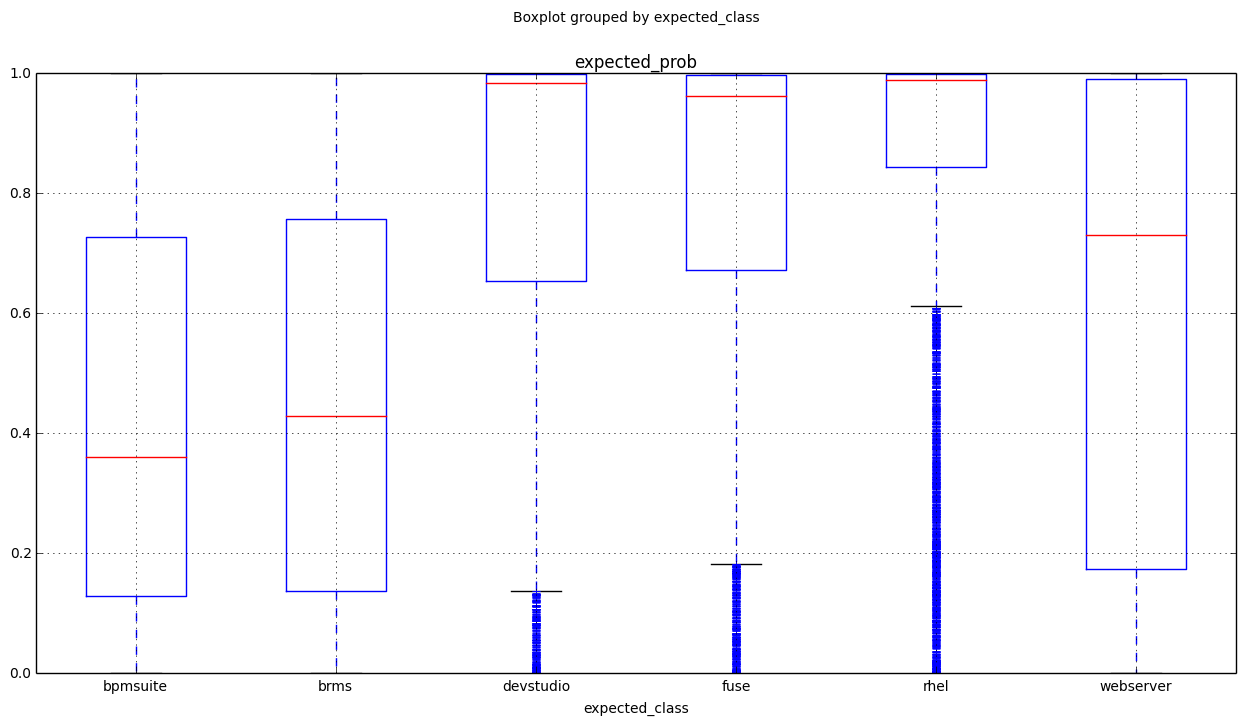

In [18]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(15,8))